In [27]:
%load_ext autoreload
%autoreload 2
import helper_functions as hp
import numpy as np
import keras_tuner
import gc
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import tensorflow as tf
tf.version.VERSION
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  2


2023-04-12 09:54:30.624094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-04-12 09:54:30.624337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 9435 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9158992224524309879
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10100736000
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9733536647615637039
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 9893969920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1135294034150404380
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5"
 xla_global_id: 2144165316]

**Loading in Data** - Functions to load in data and preprocess

In [3]:
Pocket_images, Pocket_labels = hp.segmented_dataset_reader('PocketN_6_64')
Nuns_images, Nuns_labels = hp.segmented_dataset_reader('NunsN_6_64')
Tubbs_images, Tubbs_labels = hp.segmented_dataset_reader('tubbsN_6_64')

reading in 2396 images
reading in 4554 images
reading in 3380 images


In [4]:
print(Pocket_images.shape, Pocket_labels.shape)
print(Pocket_images.dtype, Pocket_labels.dtype)
print(Nuns_images.shape, Nuns_labels.shape)
print(Nuns_images.dtype, Nuns_labels.dtype)
print(Tubbs_images.shape, Tubbs_labels.shape)
print(Tubbs_images.dtype, Tubbs_labels.dtype)

(2396, 128, 128, 4) (2396, 128, 128)
float32 uint8
(4554, 128, 128, 4) (4554, 128, 128)
float32 uint8
(3380, 128, 128, 4) (3380, 128, 128)
float32 uint8


In [5]:
Pocket_images = Pocket_images[:, :, :, 0:3]
Nuns_images = Nuns_images[:, :, :, 0:3]
Tubbs_images = Tubbs_images[:, :, :, 0:3]

In [6]:
print(np.unique(Pocket_labels, return_counts=True))
print(np.unique(Nuns_labels, return_counts=True))
print(np.unique(Tubbs_labels, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([     20, 8979703, 7948262, 5928398, 3801817, 2838297, 9759567]))
(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([      13,  4927423,  8736810,  8315235,  6385972,  5864969,
       40382314]))
(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([      14,  5480258,  8522308,  5499572,  4164987,  4386158,
       27324623]))


In [7]:
Pocket_labels = np.where(Pocket_labels == 0, Pocket_labels + 1, Pocket_labels) - 1
Nuns_labels = np.where(Nuns_labels == 0, Nuns_labels + 1, Nuns_labels) - 1
Tubbs_labels = np.where(Tubbs_labels == 0, Tubbs_labels + 1, Tubbs_labels) - 1

In [8]:
print(np.unique(Pocket_labels, return_counts=True))
print(np.unique(Nuns_labels, return_counts=True))
print(np.unique(Tubbs_labels, return_counts=True))

(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([8979723, 7948262, 5928398, 3801817, 2838297, 9759567]))
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([ 4927436,  8736810,  8315235,  6385972,  5864969, 40382314]))
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([ 5480272,  8522308,  5499572,  4164987,  4386158, 27324623]))


**Displaying images and labels**

0.6862745 0.019607844
float32
(128, 128, 3)


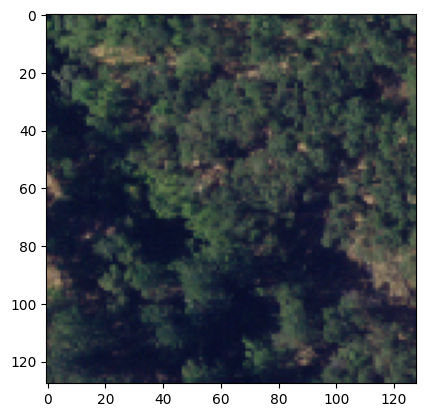

In [ ]:
img = Pocket_images[200]
print(img.max(), img.min())
print(img.dtype)
print(img.shape)
plt.imshow(img, vmax=1, vmin=0)

0.7882353 0.101960786
float32
(128, 128, 3)


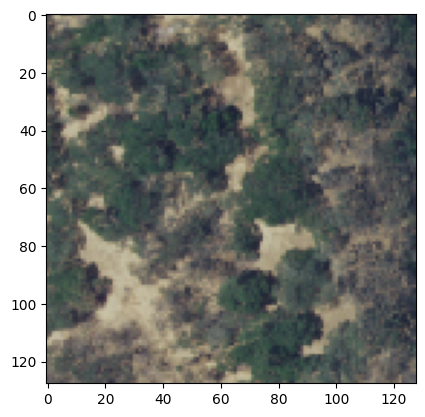

In [11]:
img = Nuns_images[350]
print(img.max(), img.min())
print(img.dtype)
print(img.shape)
plt.imshow(img)

(128, 128)
[0 1]
1 0
uint8


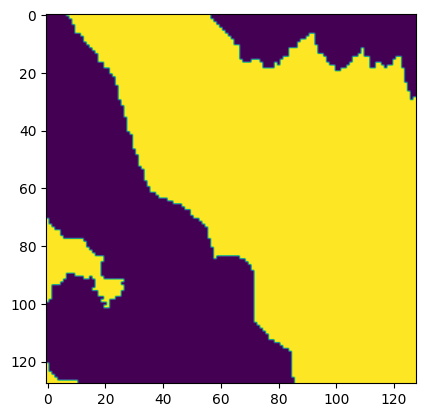

In [12]:
lbl = Pocket_labels[200]
print(lbl.shape)
print(np.unique(lbl))
print(lbl.max(), lbl.min())
print(lbl.dtype)
plt.imshow(lbl)

**Creating training and testing datasets** - creating the training and testing datasets and generating class weights

In [9]:
train_images = np.concatenate((Nuns_images, Tubbs_images), axis=0)
train_labels = np.concatenate((Nuns_labels, Tubbs_labels), axis=0)
test_images = Pocket_images
test_labels = Pocket_labels

In [10]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes= np.unique(train_labels.flatten()), y = train_labels.flatten())
print(class_weights)

In [7]:
# del Pocket_images
# del Pocket_labels
# del Nuns_images
# del Nuns_labels
# del Tubbs_images
# del Tubbs_labels

In [12]:
print(train_images.shape, train_labels.shape)
print(train_images.dtype, train_labels.dtype)
print(np.unique(train_labels, return_counts=True))
print(test_images.shape, test_labels.shape)
print(test_images.dtype, test_labels.dtype)

(7934, 128, 128, 3) (7934, 128, 128)
float32 uint8
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([10407708, 17259118, 13814807, 10550959, 10251127, 67706937]))
(2396, 128, 128, 3) (2396, 128, 128)
float32 uint8


**Hyper parameter optimization** - hyperparameter optimzation using keras tuner

In [35]:
# Creating alias for leaky_relu
from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'leaky_relu': keras.layers.LeakyReLU()})

In [ ]:
#All my callback are called here
r_lr = hp.reduce_lr()
e_stop = hp.early_stop()
callbacks = [r_lr, e_stop]
gc.collect()

In [63]:
#simple unet keras tuner builder
def build_Unet(hpf):
        _act = hpf.Choice("activation",['relu', 'elu', 'leaky_relu'])
        _drop = hpf.Choice("dropout", [0.2,0.3,0.4])
        _drop2 = hpf.Choice("dropout2", [0.2,0.3,0.4])
        _drop_bool = hpf.Boolean("dropout_bool") 
        _drop_bool2 = hpf.Boolean("dropout_bool2")
        _filter = hpf.Choice("filters", [16,32,48,64])
        _act2 = hpf.Choice("activation2",['relu', 'elu', 'leaky_relu'])
        _gamma = hpf.Choice("gamma",[1,2,3])
        _lr = hpf.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        _opt = hpf.Choice("optimizer", ['adam','Sgd'])
        model = hp.build_unet_model(6,act=_act, drop=_drop, drop2=_drop2,
                                drop_bool=_drop_bool, drop_bool2=_drop_bool2,
                                filter=_filter, act2=_act2, gamma=_gamma, lr=_lr, opt=_opt)
        return model


In [64]:
#keras_tuner hyperband object
_meaniou = keras_tuner.Objective('val_mean_io_u', 'max')
tuner = keras_tuner.Hyperband(
    hypermodel= build_Unet,
    objective= _meaniou,
    max_epochs=2,
    factor=3,
    hyperband_iterations=1,
    directory="hp_results_2",
    project_name="canopy_fire",
    overwrite=True,
)

In [65]:
#performs hyper parameter optimization
tuner.search(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    callbacks=callbacks,
    batch_size = 16,
)

Trial 2 Complete [00h 00m 49s]
val_mean_io_u: 0.300241082906723

Best val_mean_io_u So Far: 0.300241082906723
Total elapsed time: 00h 02m 25s
INFO:tensorflow:Oracle triggered exit


**Fitting the optimized simple Unet**

In [31]:
history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels), batch_size=32,
                    callbacks=callbacks, shuffle=True)  #beat 0.3770

In [13]:
#model.save('simple_seg_model_full_6class_NunsTubbs.tf', overwrite=True)
#model= keras.models.load_model("simple_seg_model.h5")

INFO:tensorflow:Assets written to: simple_seg_model_full_6class_NunsTubbs.tf\assets


INFO:tensorflow:Assets written to: simple_seg_model_full_6class_NunsTubbs.tf\assets


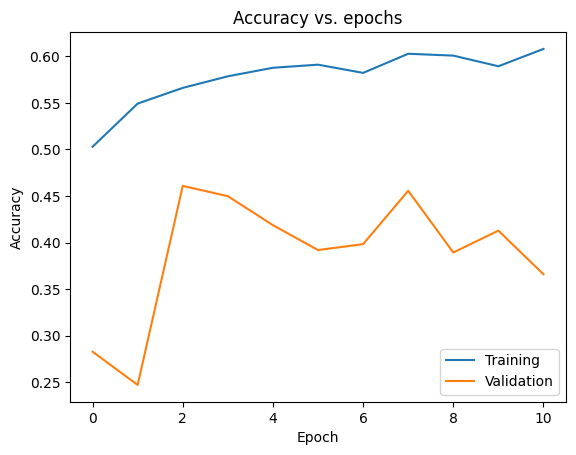

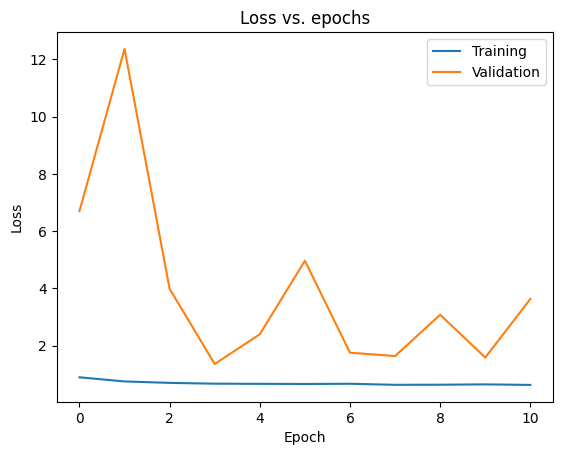

KeyError: 'mean_io_u'

In [30]:
hp.plot_accuracy(history)
hp.plot_loss(history)
hp.plot_meaniou(history)

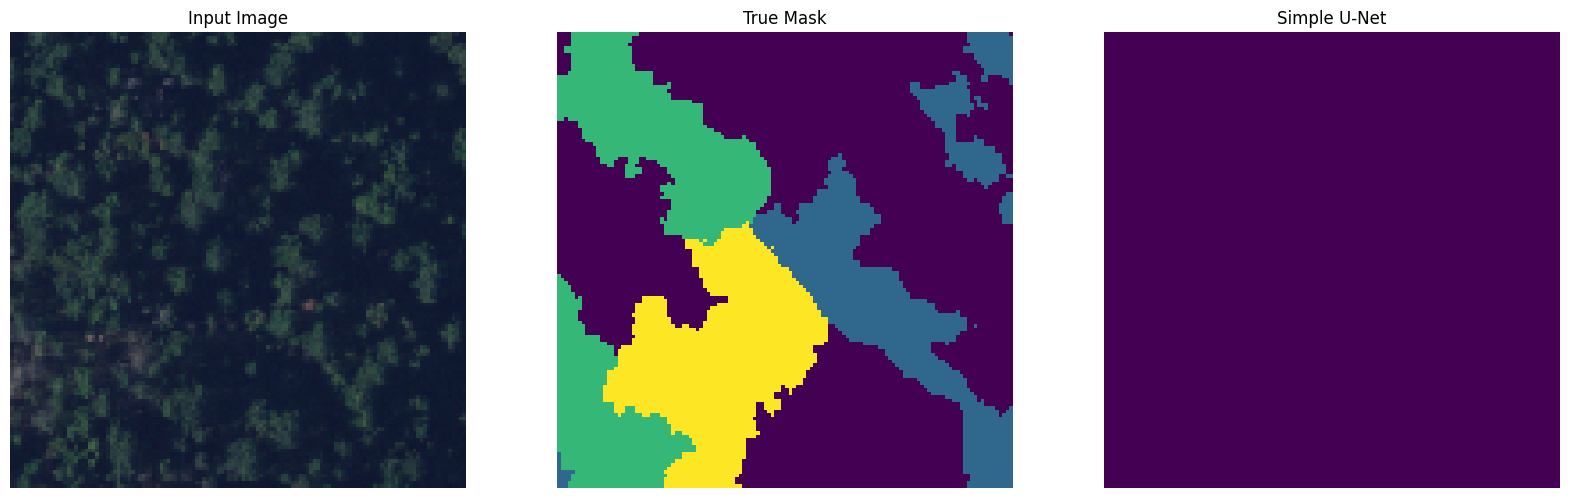

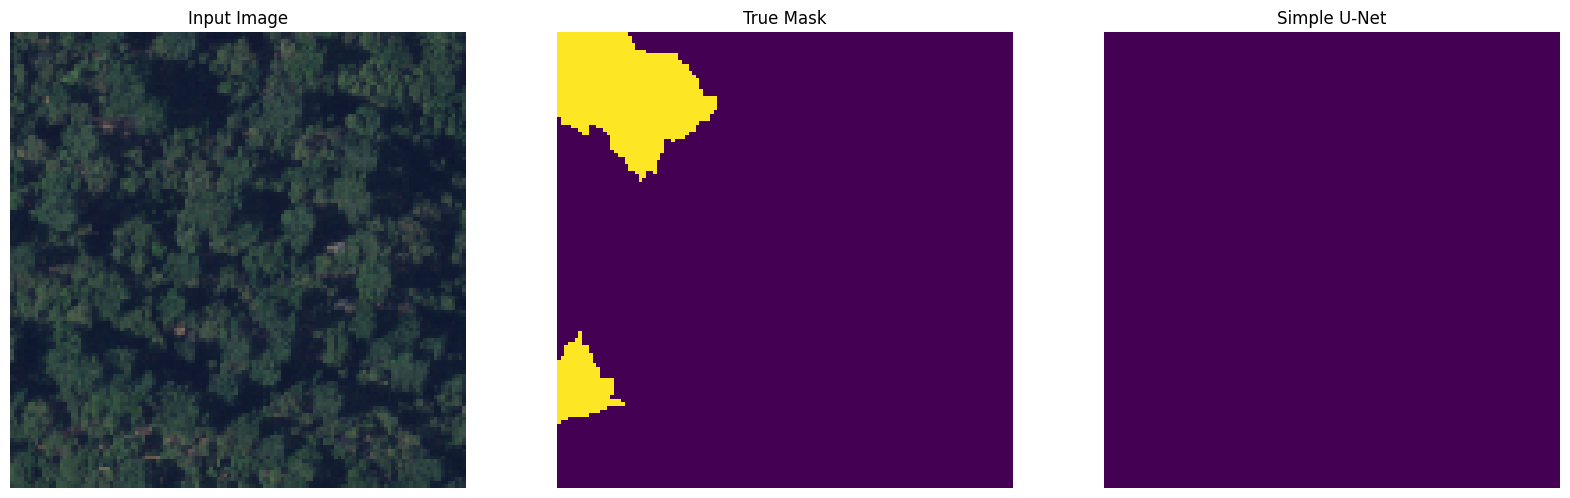

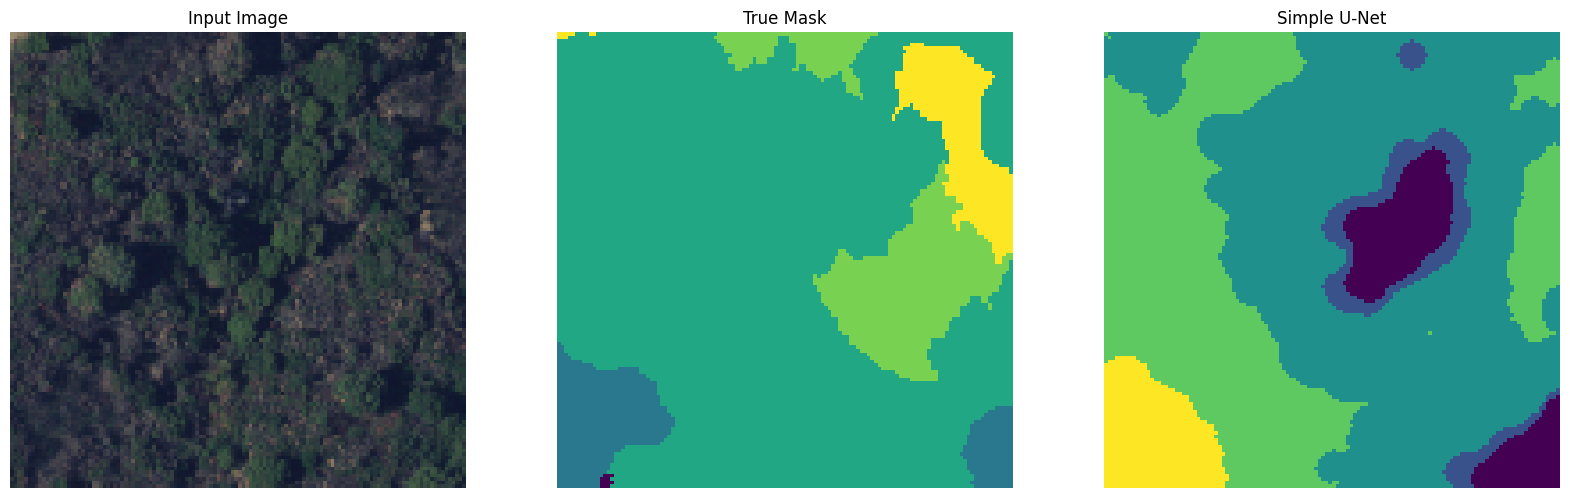

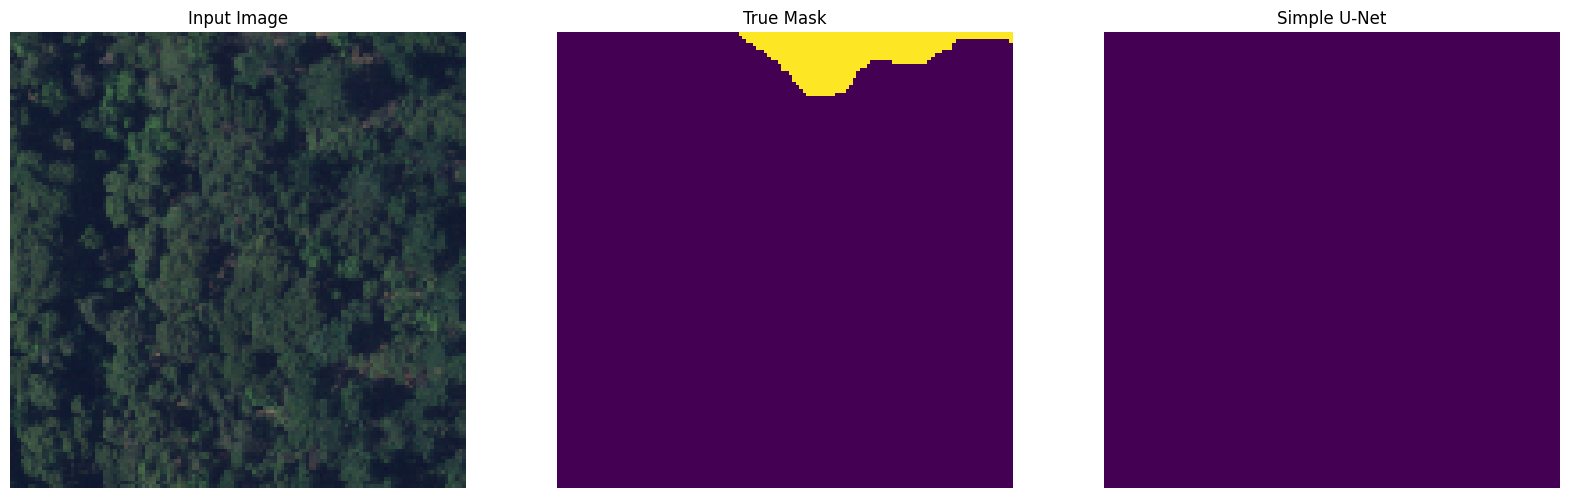

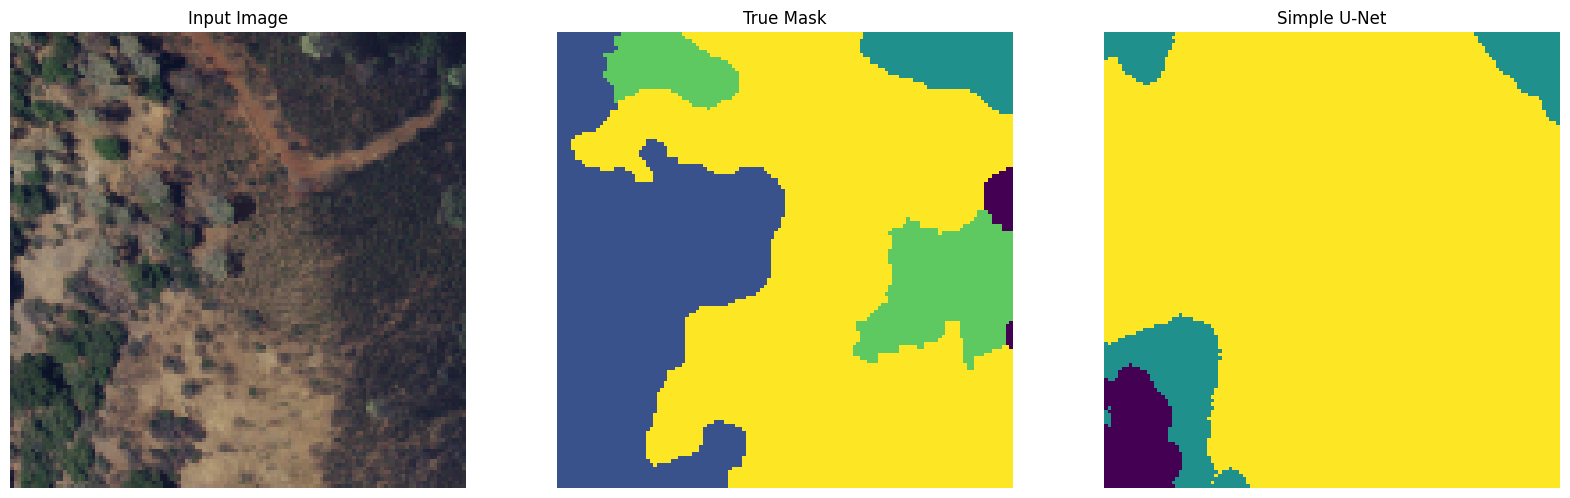

In [31]:
hp.show_predictions(model, test_images[100:105], test_labels[100:105], 5, "Simple U-Net")
#del model

**Hyper Parameter optimization of mobile Unet** - using keras tuner and hyperband


In [ ]:
def build_Unet(hpf):
        _act = hpf.Choice("activation",['relu', 'elu', 'leaky_relu'])
        _drop = hpf.Choice("dropout", [0.2,0.3,0.4])
        _drop2 = hpf.Choice("dropout2", [0.2,0.3,0.4])
        _drop_bool = hpf.Boolean("dropout_bool") 
        _drop_bool2 = hpf.Boolean("dropout_bool2")
        _filter = hpf.Choice("filters", [16,32,48,64])
        _act2 = hpf.Choice("activation2",['relu', 'elu', 'leaky_relu'])
        _gamma = hpf.Choice("gamma",[1,2,3])
        _lr = hpf.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        _opt = hpf.Choice("optimizer", ['adam','Sgd'])
        model = hp.build_unet_model(6,act=_act, drop=_drop, drop2=_drop2,
                                drop_bool=_drop_bool, drop_bool2=_drop_bool2,
                                filter=_filter, act2=_act2, gamma=_gamma, lr=_lr, opt=_opt)
        return model

**Fitting the optimized mobile Unet**

In [15]:
keras.backend.clear_session()
model_mobile = hp.mobile_unet_model(output_channels=6, weights=class_weights)
model_mobile.summary()
gc.collect()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_1[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

40354

In [16]:
gc.collect()

0

In [17]:
history_mobile = model_mobile.fit(train_images, train_labels, epochs=50, batch_size=32,
                                  validation_data=(test_images, test_labels),
                                  callbacks=callbacks, shuffle=True)  #.3175

Epoch 1/50
744/744 [==============================] - 25s 31ms/step - loss: 0.8689 - accuracy: 0.5323 - mean_io_u: 0.2629 - val_loss: 1.2670 - val_accuracy: 0.4160 - val_mean_io_u: 0.2527
Epoch 2/50
744/744 [==============================] - 21s 28ms/step - loss: 0.7291 - accuracy: 0.5823 - mean_io_u: 0.3065 - val_loss: 1.2118 - val_accuracy: 0.4571 - val_mean_io_u: 0.2659
Epoch 3/50
744/744 [==============================] - 21s 28ms/step - loss: 0.7052 - accuracy: 0.5894 - mean_io_u: 0.3139 - val_loss: 1.2339 - val_accuracy: 0.4404 - val_mean_io_u: 0.2669
Epoch 4/50
744/744 [==============================] - 21s 28ms/step - loss: 0.6940 - accuracy: 0.5924 - mean_io_u: 0.3177 - val_loss: 1.2054 - val_accuracy: 0.4530 - val_mean_io_u: 0.2740
Epoch 5/50
744/744 [==============================] - 21s 28ms/step - loss: 0.6845 - accuracy: 0.5971 - mean_io_u: 0.3213 - val_loss: 1.2061 - val_accuracy: 0.4534 - val_mean_io_u: 0.2744
Epoch 6/50
744/744 [==============================] - 21s 28

In [65]:
#model_mobile = keras.models.load_model("mobilenet_seg_model_full.tf")

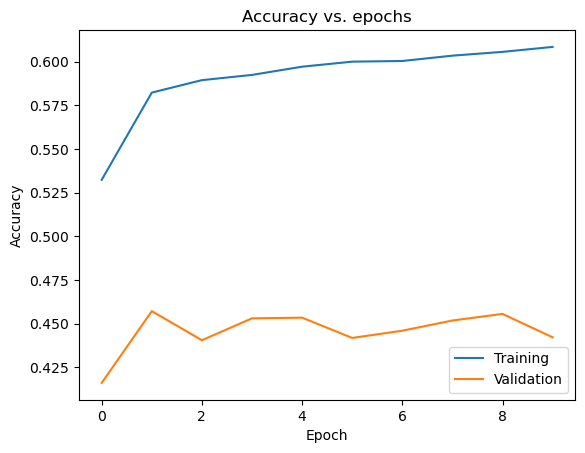

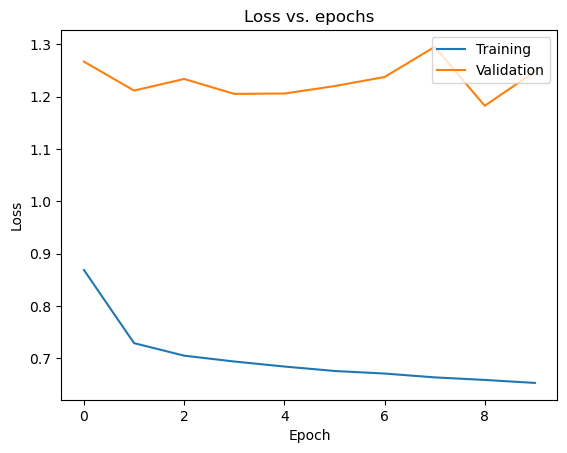

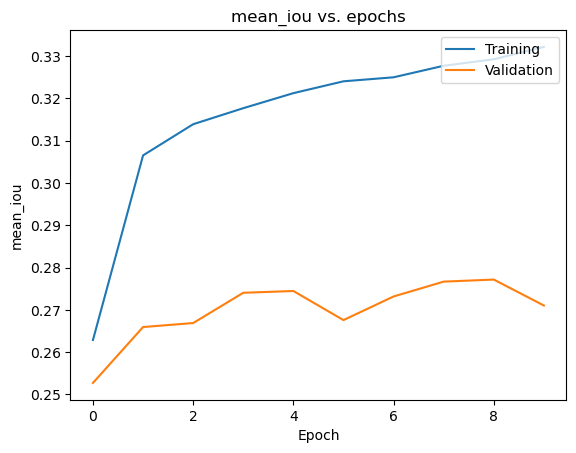

In [18]:
hp.plot_accuracy(history_mobile)
hp.plot_loss(history_mobile)
hp.plot_meaniou(history_mobile)

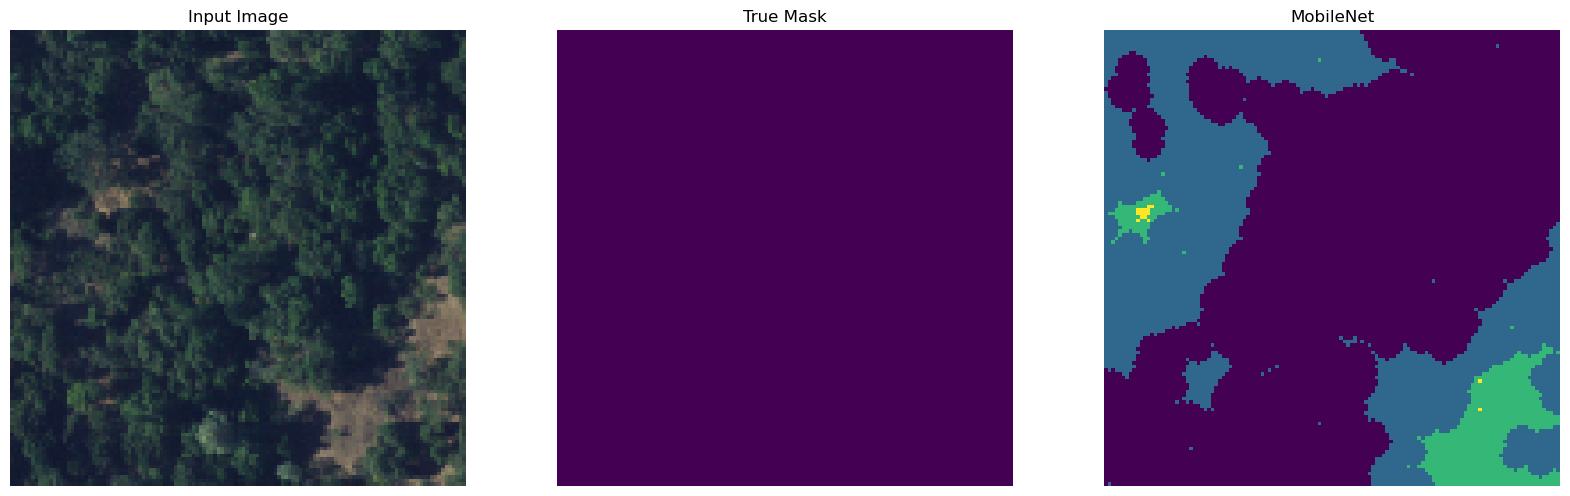

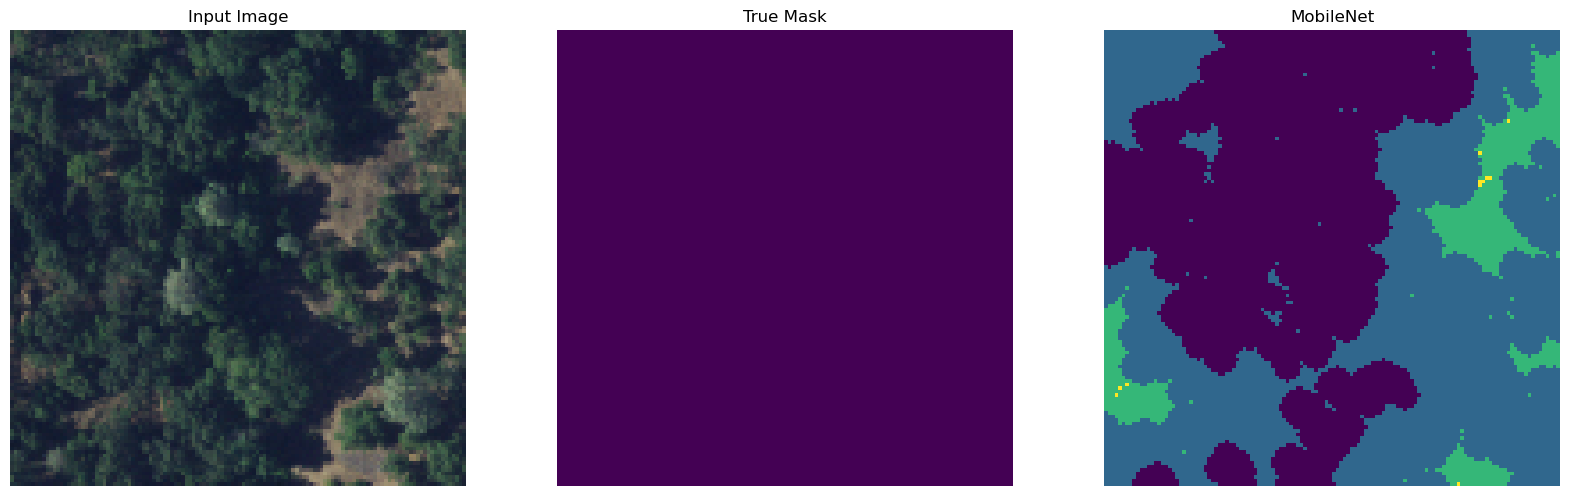

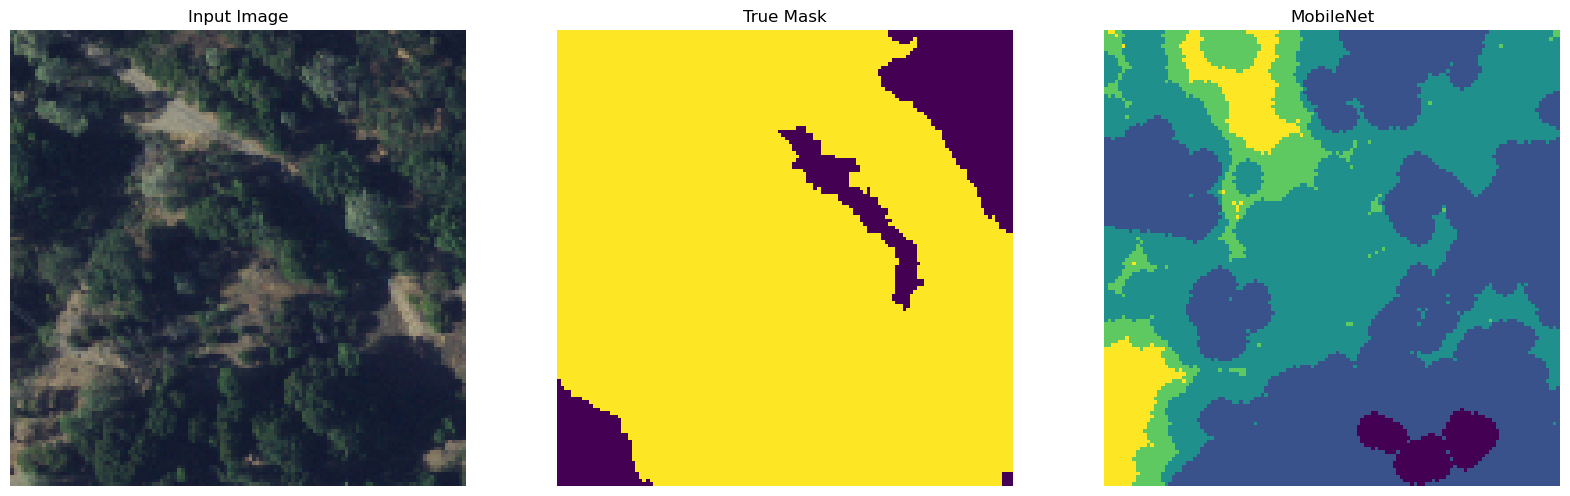

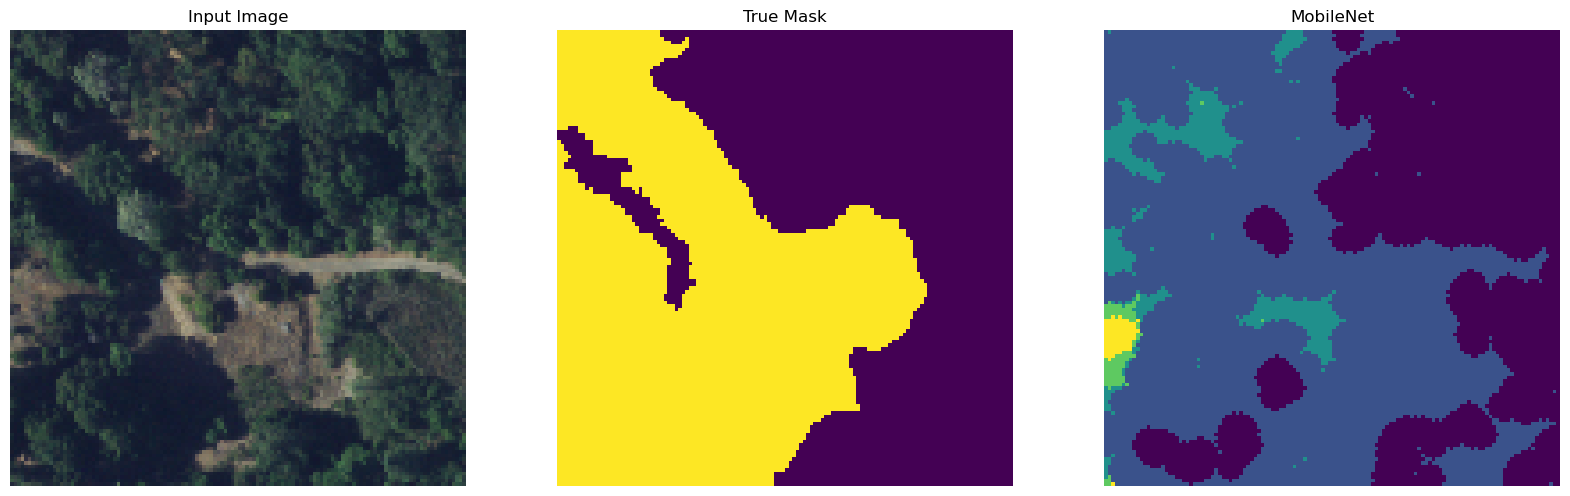

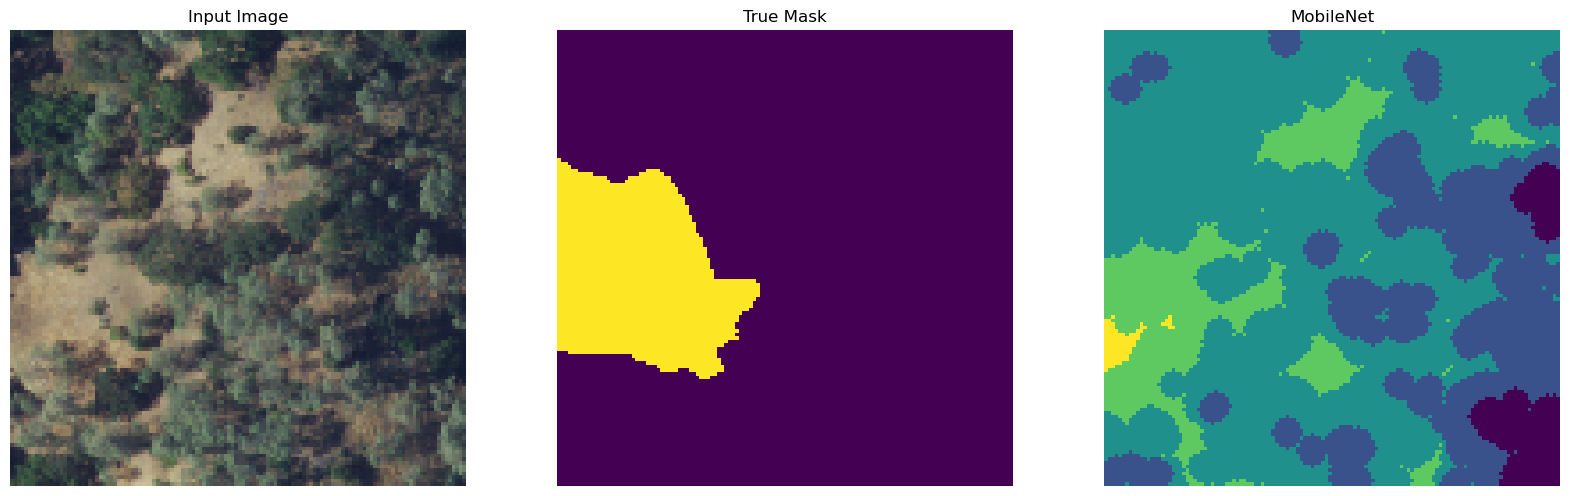

In [19]:
hp.show_predictions(model_mobile, test_images[100:105], test_labels[100:105], 5, "MobileNet")

In [21]:
model_mobile.save('mobilenet_seg_model_full_6class_NunsTubbs.tf', overwrite=True)

INFO:tensorflow:Assets written to: mobilenet_seg_model_full_6class_NunsTubbs.tf\assets


INFO:tensorflow:Assets written to: mobilenet_seg_model_full_6class_NunsTubbs.tf\assets


In [20]:
keras.backend.clear_session()
model_deeplab = hp.DeeplabV3Plus(image_size=128, num_classes=6, weight=class_weights)
model_deeplab.summary()
gc.collect()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

360

In [21]:
dlab_history = model_deeplab.fit(train_images, train_labels, epochs=50, batch_size=32,
                                 validation_data=(test_images, test_labels),
                                 callbacks=callbacks, shuffle=True)

Epoch 1/50
744/744 [==============================] - 63s 79ms/step - loss: 0.9777 - accuracy: 0.4075 - mean_io_u: 0.2047 - val_loss: 30.3017 - val_accuracy: 0.2319 - val_mean_io_u: 0.0561
Epoch 2/50
744/744 [==============================] - 57s 76ms/step - loss: 0.6782 - accuracy: 0.5745 - mean_io_u: 0.3132 - val_loss: 1.1072 - val_accuracy: 0.4735 - val_mean_io_u: 0.3008
Epoch 3/50
744/744 [==============================] - 57s 76ms/step - loss: 0.6223 - accuracy: 0.6011 - mean_io_u: 0.3358 - val_loss: 1.1412 - val_accuracy: 0.4547 - val_mean_io_u: 0.2896
Epoch 4/50
744/744 [==============================] - 57s 76ms/step - loss: 0.5744 - accuracy: 0.6231 - mean_io_u: 0.3569 - val_loss: 1.1401 - val_accuracy: 0.4629 - val_mean_io_u: 0.2944
Epoch 5/50
744/744 [==============================] - 57s 76ms/step - loss: 0.5373 - accuracy: 0.6372 - mean_io_u: 0.3738 - val_loss: 1.1820 - val_accuracy: 0.4598 - val_mean_io_u: 0.2932
Epoch 6/50
744/744 [==============================] - 57s 7

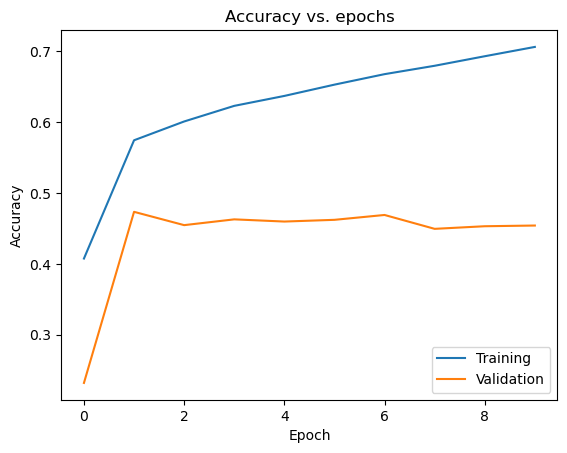

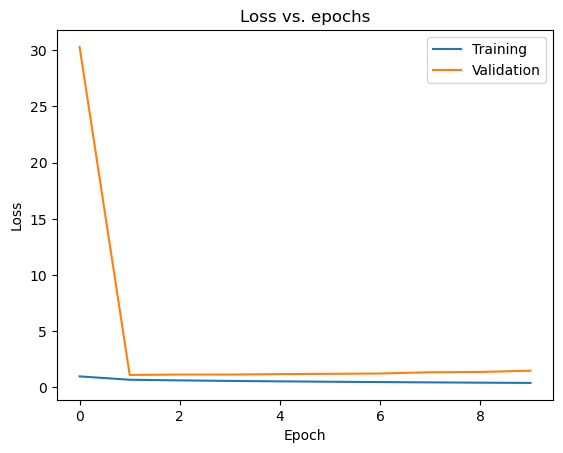

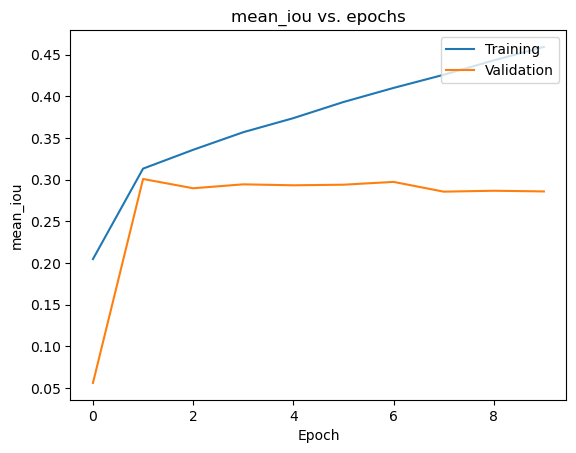

In [22]:
hp.plot_accuracy(dlab_history)
hp.plot_loss(dlab_history)
hp.plot_meaniou(dlab_history)

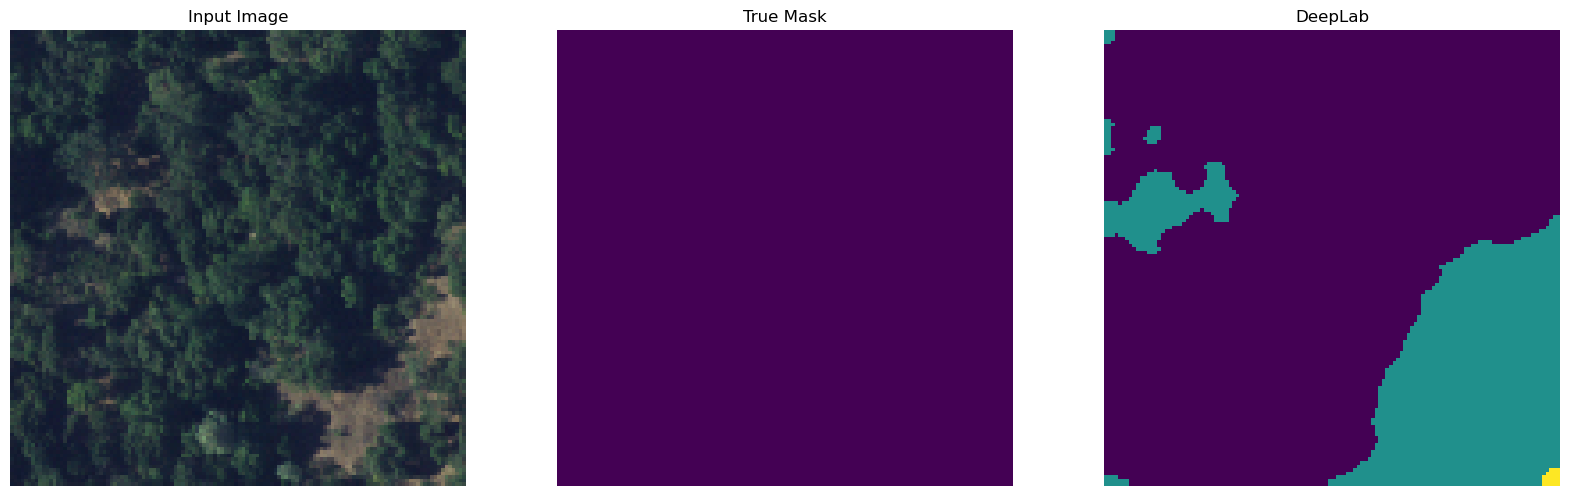

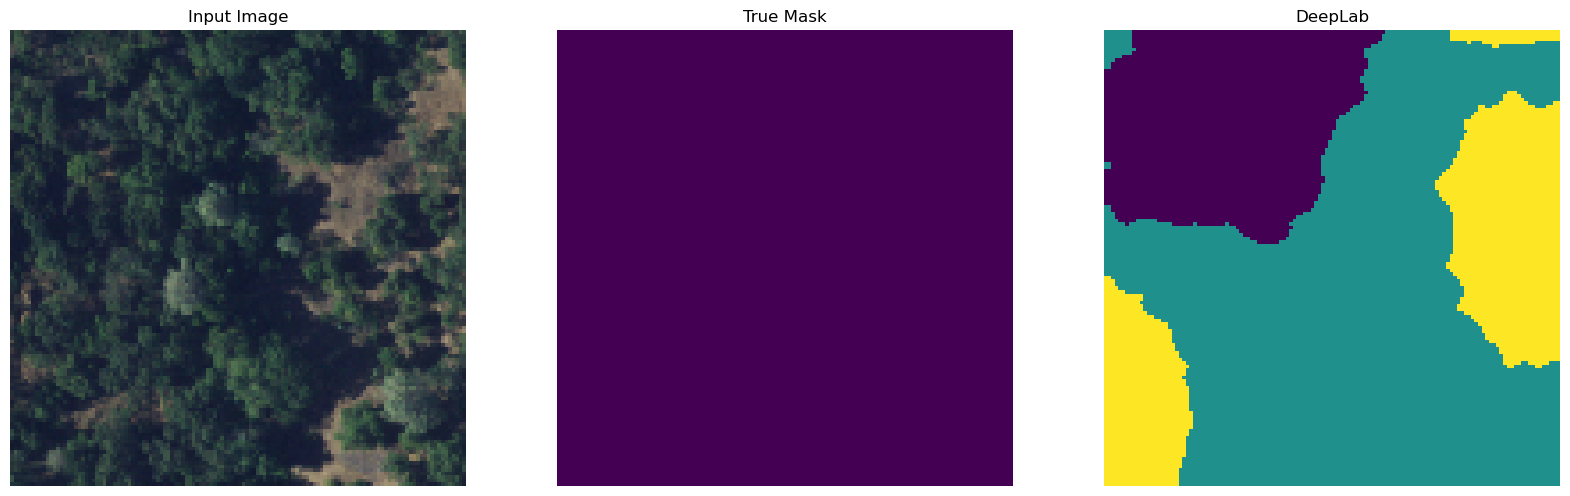

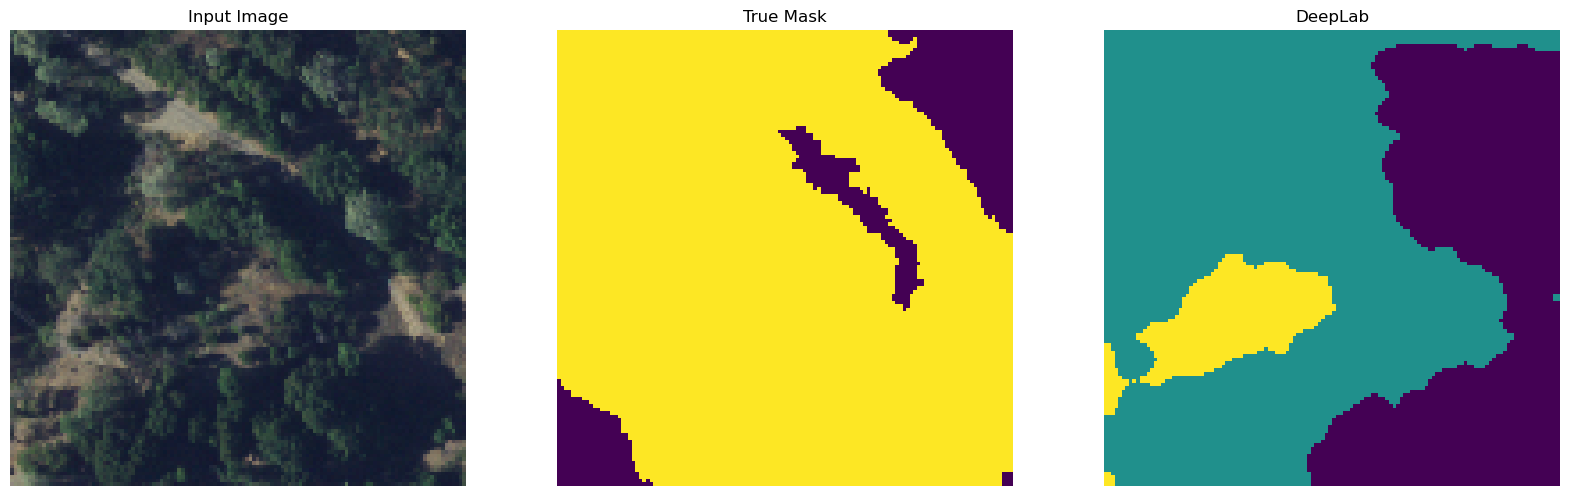

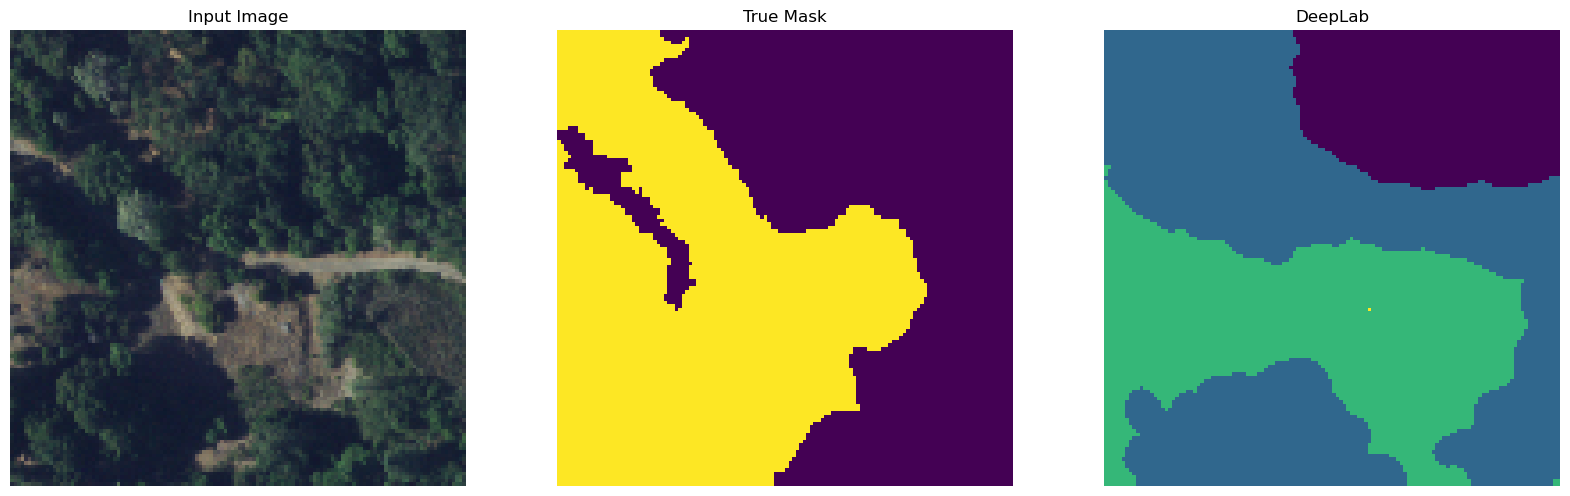

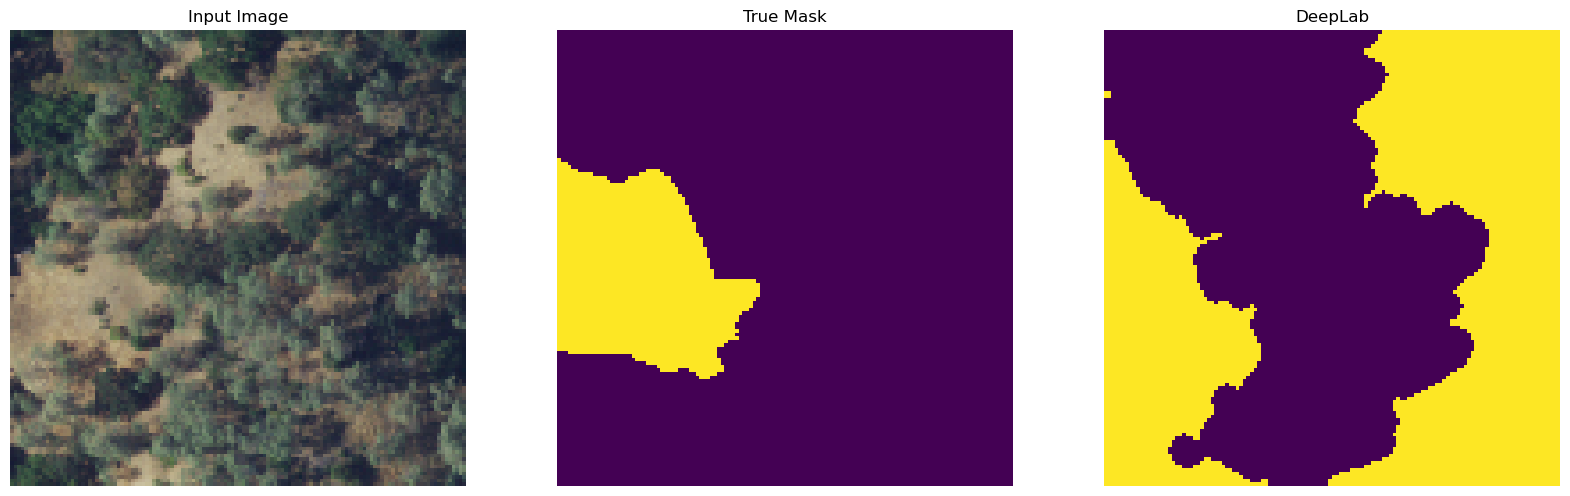

In [23]:
hp.show_predictions(model_deeplab, test_images[100:105], test_labels[100:105], 5, "DeepLab")

In [26]:
model_deeplab.save('deeplabv3_seg_model_full_6class_NunsTubbs.tf', overwrite=True)

INFO:tensorflow:Assets written to: deeplabv3_seg_model_full_6class_NunsTubbs.tf\assets


INFO:tensorflow:Assets written to: deeplabv3_seg_model_full_6class_NunsTubbs.tf\assets


In [30]:
gc.collect()
del model_deeplab
del model_mobile
del model

NameError: name 'model_deeplab' is not defined

In [6]:
final_images = np.concatenate((train_images, test_images), axis=0)
final_labels = np.concatenate((train_labels, test_labels), axis=0)

In [7]:
del train_labels
del train_images
del test_labels
del test_images

In [8]:
print(final_images, final_labels.shape)

(30994, 128, 128, 3) (30994, 128, 128)


In [5]:
gc.collect()

0

In [6]:
# gc.collect()
# svote_mask_tubbs = hp.voting(['deeplabv3_seg_model_full_6class_NunsTubbs.tf','deeplabv3_seg_model_full_6class_PocketTubbs.tf','deeplabv3_seg_model_full_6class_PocketNuns.tf',
#                         'mobilenet_seg_model_full_6class_NunsTubbs.tf','mobilenet_seg_model_full_6class_PocketNuns.tf','mobilenet_seg_model_full_6class_PocketTubbs.tf',
#                         'simple_seg_model_full_6class_NunsTubbs.tf','simple_seg_model_full_6class_PocketNuns.tf', 'simple_seg_model_full_6class_PocketTubbs.tf' ],
#                        Tubbs_images, Tubbs_labels, offset=25, num=5)

deeplabv3_seg_model_full_6class_NunsTubbs.tf
deeplabv3_seg_model_full_6class_PocketTubbs.tf
deeplabv3_seg_model_full_6class_PocketNuns.tf
mobilenet_seg_model_full_6class_NunsTubbs.tf
mobilenet_seg_model_full_6class_PocketNuns.tf
mobilenet_seg_model_full_6class_PocketTubbs.tf
simple_seg_model_full_6class_NunsTubbs.tf
simple_seg_model_full_6class_PocketNuns.tf
simple_seg_model_full_6class_PocketTubbs.tf
s_voting
0.42766634


In [6]:
gc.collect()
svote_mask_tubbs = hp.voting(['deeplabv3_seg_model_full_6class_PocketNuns.tf',
                        'mobilenet_seg_model_full_6class_PocketNuns.tf',
                        'simple_seg_model_full_6class_PocketNuns.tf'],
                       Tubbs_images, Tubbs_labels, offset=25, num=5)

deeplabv3_seg_model_full_6class_PocketNuns.tf
mobilenet_seg_model_full_6class_PocketNuns.tf
simple_seg_model_full_6class_PocketNuns.tf
s_voting
0.33018968


In [8]:
# gc.collect()
# svote_mask_Pocket = hp.voting(['deeplabv3_seg_model_full_6class_NunsTubbs.tf','deeplabv3_seg_model_full_6class_PocketTubbs.tf','deeplabv3_seg_model_full_6class_PocketNuns.tf',
#                         'mobilenet_seg_model_full_6class_NunsTubbs.tf','mobilenet_seg_model_full_6class_PocketNuns.tf','mobilenet_seg_model_full_6class_PocketTubbs.tf',
#                         'simple_seg_model_full_6class_NunsTubbs.tf','simple_seg_model_full_6class_PocketNuns.tf', 'simple_seg_model_full_6class_PocketTubbs.tf' ],
#                        Pocket_images, Pocket_labels, offset=25, num=5)

deeplabv3_seg_model_full_6class_NunsTubbs.tf
deeplabv3_seg_model_full_6class_PocketTubbs.tf
deeplabv3_seg_model_full_6class_PocketNuns.tf
mobilenet_seg_model_full_6class_NunsTubbs.tf
mobilenet_seg_model_full_6class_PocketNuns.tf
mobilenet_seg_model_full_6class_PocketTubbs.tf
simple_seg_model_full_6class_NunsTubbs.tf
simple_seg_model_full_6class_PocketNuns.tf
simple_seg_model_full_6class_PocketTubbs.tf
s_voting
0.43943903


In [7]:
gc.collect()
svote_mask_Pocket = hp.voting(['deeplabv3_seg_model_full_6class_NunsTubbs.tf',
                        'mobilenet_seg_model_full_6class_NunsTubbs.tf',
                        'simple_seg_model_full_6class_NunsTubbs.tf' ],
                       Pocket_images, Pocket_labels, offset=25, num=5)

deeplabv3_seg_model_full_6class_NunsTubbs.tf
mobilenet_seg_model_full_6class_NunsTubbs.tf
simple_seg_model_full_6class_NunsTubbs.tf
s_voting
0.3443286


In [10]:
# gc.collect()
# svote_mask_Nuns = hp.voting(['deeplabv3_seg_model_full_6class_NunsTubbs.tf','deeplabv3_seg_model_full_6class_PocketTubbs.tf','deeplabv3_seg_model_full_6class_PocketNuns.tf',
#                         'mobilenet_seg_model_full_6class_NunsTubbs.tf','mobilenet_seg_model_full_6class_PocketNuns.tf','mobilenet_seg_model_full_6class_PocketTubbs.tf',
#                         'simple_seg_model_full_6class_NunsTubbs.tf','simple_seg_model_full_6class_PocketNuns.tf', 'simple_seg_model_full_6class_PocketTubbs.tf' ],
#                        Nuns_images, Nuns_labels, offset=25, num=5)

deeplabv3_seg_model_full_6class_NunsTubbs.tf
deeplabv3_seg_model_full_6class_PocketTubbs.tf
deeplabv3_seg_model_full_6class_PocketNuns.tf
mobilenet_seg_model_full_6class_NunsTubbs.tf
mobilenet_seg_model_full_6class_PocketNuns.tf
mobilenet_seg_model_full_6class_PocketTubbs.tf
simple_seg_model_full_6class_NunsTubbs.tf
simple_seg_model_full_6class_PocketNuns.tf
simple_seg_model_full_6class_PocketTubbs.tf
s_voting
0.33543143


In [8]:
gc.collect()
svote_mask_Nuns = hp.voting(['deeplabv3_seg_model_full_6class_PocketTubbs.tf',
                        'mobilenet_seg_model_full_6class_PocketTubbs.tf',
                         'simple_seg_model_full_6class_PocketTubbs.tf' ],
                       Nuns_images, Nuns_labels, offset=25, num=5)

deeplabv3_seg_model_full_6class_PocketTubbs.tf
mobilenet_seg_model_full_6class_PocketTubbs.tf
simple_seg_model_full_6class_PocketTubbs.tf
s_voting
0.28059795


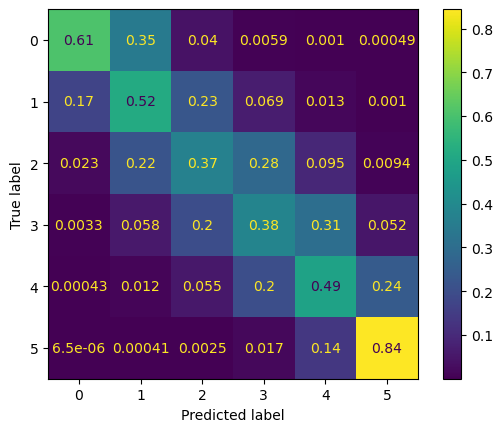

In [9]:
flat_preds = np.concatenate(svote_mask_tubbs).flatten()
flat_truth = np.concatenate(Tubbs_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

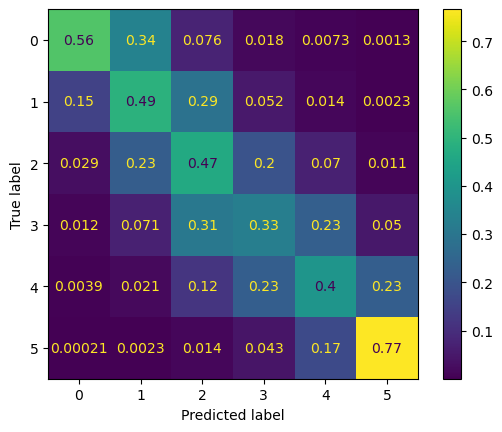

In [10]:
gc.collect()
flat_preds = np.concatenate(svote_mask_Pocket).flatten()
flat_truth = np.concatenate(Pocket_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

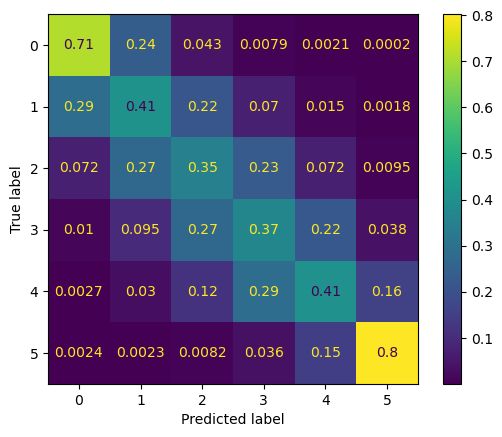

In [11]:
gc.collect()
flat_preds = np.concatenate(svote_mask_Nuns).flatten()
flat_truth = np.concatenate(Nuns_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [12]:
#final_images = np.concatenate(Pocket_images,Tubbs_images,Nuns_images, axis =0)
final_labels = np.concatenate((Pocket_labels,Tubbs_labels,Nuns_labels), axis =0)
svote_mask_final = np.concatenate((svote_mask_Pocket,svote_mask_tubbs,svote_mask_Nuns), axis = 0)

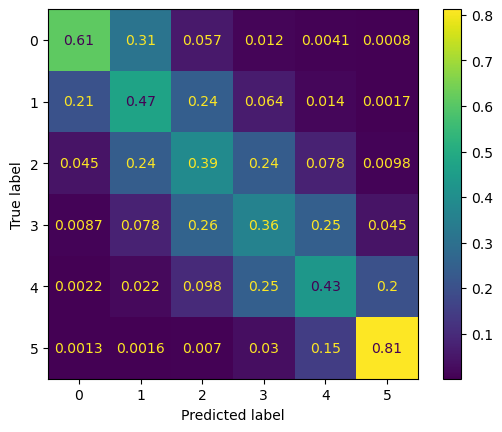

In [13]:
gc.collect()
flat_preds = np.concatenate(svote_mask_final).flatten()
flat_truth = np.concatenate(final_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [14]:
np.unique(final_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([ 58714287,  75771302,  58164755,  41895012,  39142878, 234117462],
       dtype=int64))

In [15]:
svote_mask_final_bin = np.copy(svote_mask_final)
final_labels_bin = np.copy(final_labels)

In [16]:
flat_preds = np.concatenate(svote_mask_final_bin).flatten()
flat_truth = np.concatenate(final_labels_bin).flatten()

In [17]:
print(np.unique(flat_preds))
print(np.unique(flat_truth))

[0 1 2 3 4 5]
[0 1 2 3 4 5]


In [18]:
preds0 = np.where(flat_preds==0)
preds12 = np.where((flat_preds==1) | (flat_preds==2))
preds34 = np.where((flat_preds==3) | (flat_preds==4))
preds5 = np.where(flat_preds==5)

In [51]:
print(preds34)
print(preds5)
print(preds12)
print(preds0)

(array([    16444,     16445,     16446, ..., 507729404, 507729405,
       507729406], dtype=int64),)
(array([   196608,    196609,    196610, ..., 507805693, 507805694,
       507805695], dtype=int64),)
(array([        0,         1,         2, ..., 507007489, 507007491,
       507007617], dtype=int64),)
(array([   114693,    114694,    114695, ..., 502103980, 502103981,
       502103982], dtype=int64),)


In [19]:
flat_preds[preds0]=0
flat_preds[preds12]=1
flat_preds[preds34]=2
flat_preds[preds5]=3

In [20]:
truth0 = np.where((flat_truth == 0))
truth12 = np.where((flat_truth == 1) | (flat_truth == 2))
truth34 = np.where((flat_truth == 3) | (flat_truth == 4))
truth5 = np.where((flat_truth == 5))
flat_truth[truth0]=0
flat_truth[truth12] = 1
flat_truth[truth34] = 2
flat_truth[truth5] = 3

In [21]:
print(flat_truth.shape)

(507805696,)


In [22]:
print(flat_preds.shape)

(507805696,)


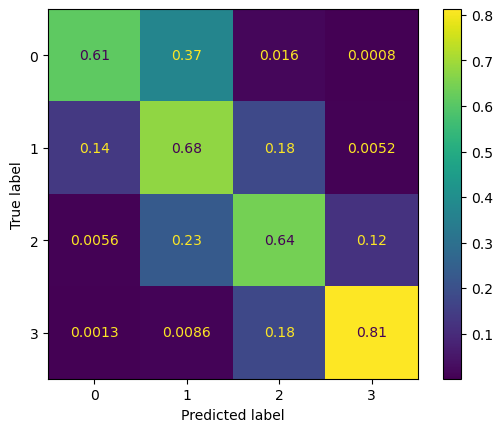

In [23]:
gc.collect()
# flat_preds = np.concatenate(svote_mask_final_bin).flatten()
# flat_truth = np.concatenate(final_labels_bin).flatten()
OUTPUT_CHANNELS = 4
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [ ]:
# Class   Damage
# 0	    <%5
# 1 	    5%-20%
# 2	    20%-40%
# 3	    40%-60%
# 4	    60%-80%
# 5	    80%-100%